# Preprocess
In this notebook, we look at the dataset and perform some preprocessing to improve the quality of the dataset.

We start by importing some libaries and setting some constants:

In [1]:
# os to read 
import os
from tqdm import tqdm

# contextlib to supress some errors
from contextlib import suppress

# numpy and pandas for manipulating data
import numpy as np
import pandas as pd

# matplotlib to visualize 
import matplotlib as mpl
from matplotlib import pyplot as plt

# Libraries for performing some basic image processing
import cv2
import skimage.color
import skimage.segmentation
import skimage.filters

from sklearn.model_selection import train_test_split

# Seed for reproducing some random results
SEED = 4

Here's the structure of the database (located one directory above this one).

```
../database/
├──raw/                       Contains the raw dataset
   ├──food-items.txt          List of items in the dataset
   ├──links.txt               List all the links that I found the photos from
   ├──apples/                 Images are put into separate folders for each class
   ├──asparagus/
   ...
```
Let's create a pandas DataFrame containing all of the paths to the images.

In [2]:
# Get the paths to the raw image files and put them in a DataFrame
raw_paths = []

# Iterate through 'database/raw/' directory recursively
for root, directories, filenames in os.walk('../database/raw'):
    # Only get images (in subfolders)
    if not root == '../database/raw':
        for filename in filenames: 
            raw_paths.append(os.path.join(root, filename))

# Create a list of labels (../database/raw/<label>)
labels = [r.split('/')[3] for r in raw_paths]

# Create a DataFrame
df = pd.DataFrame({'raw_path': raw_paths, 'label': labels,})
df.head(5) # Show a preview

,raw_path,label
0,../database/raw/bananas/5.jpg,bananas
1,../database/raw/bananas/36.jpg,bananas
2,../database/raw/bananas/13.jpg,bananas
3,../database/raw/bananas/10.jpg,bananas
4,../database/raw/bananas/9.jpg,bananas


Let's see how many classes we have, and how many images in each class.

In [3]:
n_classes = df['label'].unique().shape[0]
images_per_class = df.shape[0] / n_classes

print("There are {} classes, with an average of {} images per class"\
      .format(n_classes, images_per_class))

There are 52 classes, with an average of 23.26923076923077 images per class


Let's look at some of the pictures to understand what they look like:

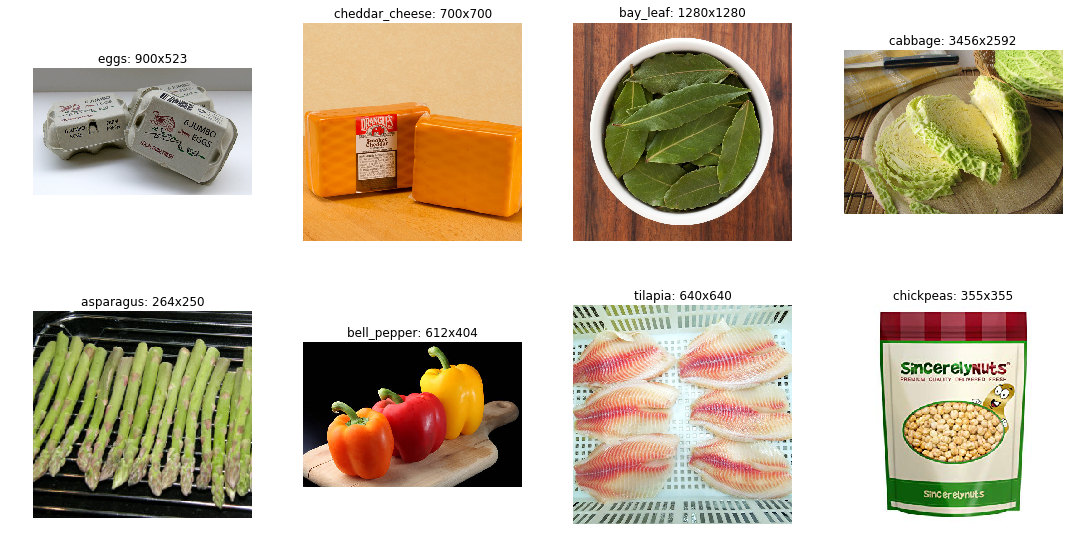

In [4]:
# Take 8 random samples from the dataset 
random_sample = df.sample(8, random_state=SEED).reset_index() 

# Note: reset_index() so we can use the index for subplot number
# Show the images
plt.figure(figsize=(15, 8))
for i, row in random_sample.iterrows():
    image = plt.imread(row['raw_path'])
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title("{}: {}x{}".format(row['label'], image.shape[1], image.shape[0]))
    plt.axis('off')
plt.tight_layout()

We can see that the images have different resolutions and aspect ratios. Furthermore, in pictures like the cabbage, we can see other items in the image.

To train a CNN to recognize images, we need each image to be the same size. It is also nice if they are focused on the labeled object. The goal of the preprocessing is to take a square crop of the most important part of each picture.

We can accomplish this using `active_contour` model. 

## Active Contour
The active contour model uses snakes to minimize 'energy' to pull the snake towards contours in an image. To use active contour, we should have a grayscale image. Also, blurring helps the snake come to equilibrium. 

Let's try it:

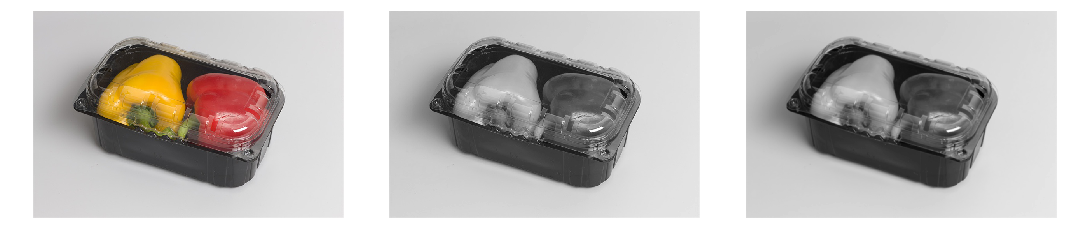

In [5]:
image = plt.imread('../database/raw/bell_pepper/9.jpg')
image_gray = skimage.color.rgb2gray(image)
image_gray_blur = skimage.filters.gaussian(image_gray, 1.028)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_gray_blur, cmap='gray')
plt.axis('off')

plt.tight_layout()    

Now, we should create a snake, and use [`skimage.segmentation.active_contour`](http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.active_contour) to shrink it to the contours in the image.

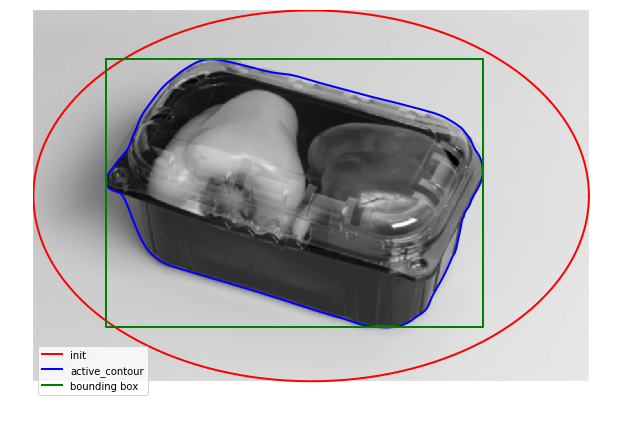

In [6]:
# Create an initial snake (just a circle)
s = np.linspace(0, 2*np.pi, 300)
x = image.shape[1] / 2 + (image.shape[1] / 2) * np.cos(s)
y = image.shape[0] / 2 + (image.shape[0] / 2) * np.sin(s)
init = np.array([x,y]).T # An array of (x,y) coordinates

# Apply active contour model
snake = skimage.segmentation.active_contour(image_gray_blur, init)

# Get the minimum bounding box for the snake
left = np.max([np.min(snake[:,0]).astype(int), 0])
right = np.min([np.max(snake[:,0]).astype(int), image.shape[1]])
top = np.max([np.min(snake[:,1]).astype(int), 0])
bottom = np.min([np.max(snake[:,1]).astype(int), image.shape[0]])

# Show the original image with initial and final snakes
plt.figure(figsize=(15, 6))
plt.imshow(image_gray_blur, cmap='gray')
plt.plot(init[:, 0], init[:, 1], 
         'r', lw=2, label="init")
plt.plot(snake[:, 0], snake[:, 1], 
         'b', lw=2, label="active_contour")
plt.plot([left, left, right, right, left], 
         [top, bottom, bottom, top, top], 
         'g', lw=2, label="bounding box")
plt.legend()
plt.axis('off')
plt.tight_layout()

We need a square crop, so we'll take a square, center crop from the bounding box.

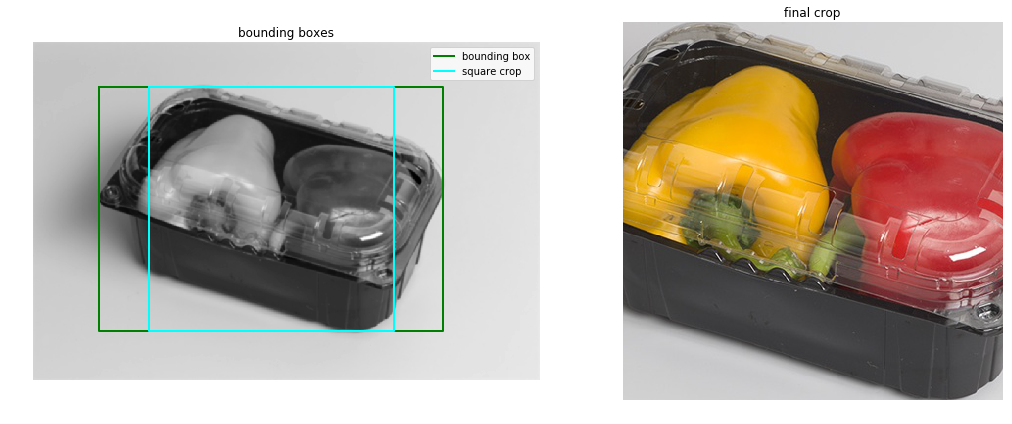

In [7]:
# Since we need a square crop, we calculate the smallest edge
side_length = np.min([right - left, bottom - top])

# Calculate the extra horizontal and vertical space
h_margin = ((right - left) - side_length)
v_margin = ((bottom - top) - side_length)

# Shrink bounding box s.t. crop is centered and square
new_left = left + h_margin  // 2
new_right = right - h_margin // 2 + (h_margin % 2)
new_top = top + v_margin // 2
new_bottom = bottom - v_margin // 2 + (v_margin % 2)

# Crop the image 
cropped_image = image[new_top:new_bottom, new_left:new_right]

# Show the bounding boxes and the final result
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_gray_blur, cmap='gray')
plt.plot([left, left, right, right, left], 
         [top, bottom, bottom, top, top], 
         'g', lw=2, label="bounding box")
plt.plot([new_left, new_left, new_right, new_right, new_left], 
         [new_top, new_bottom, new_bottom, new_top, new_top], 
         'cyan', lw=2, label="square crop")
plt.legend()
plt.axis('off')
plt.title("bounding boxes")

plt.subplot(1, 2, 2)
plt.imshow(cropped_image)
plt.axis('off')
plt.title("final crop")

plt.tight_layout()

We should create a set of functions to do this process for each image:

In [8]:
# Define functions to write, crop, and do transforms for data augmentation
def write_image(image, path):
    """Write an image to disk.
    image      (numpy.ndarray): Image in the form of 3d array to write.
        
    path                 (str): Path to target location on filesystem. 
    """
    directory = os.path.dirname(path)
    with suppress(FileExistsError):
        os.makedirs(directory)
    cv2.imwrite(path, image)

def get_bounding_box(image, snake_params):
    """Returns a bounding box for a crop using active contour snakes algorithm.
    image      (numpy.ndarray): Image in the form of 3d array to find bounding box.
    
    snake_params        (dict): Parameters to use for skimage's active_contour. 
    """

    # apply grayscale and Gaussian blur; note a=2.5 or sig=0.4472
    image_gray = skimage.color.rgb2gray(image)
    image_gray_blur = skimage.filters.gaussian(image_gray, 1.028)

    # Create an init snake (circle) and use active_contour to shrink it
    s = np.linspace(0, 2*np.pi, 300)
    x = image.shape[1] / 2 + (image.shape[1] / 2) * np.cos(s)
    y = image.shape[0] / 2 + (image.shape[0] / 2) * np.sin(s)
    
    init = np.array([x,y]).T
    snake = skimage.segmentation.active_contour(image_gray_blur, 
                                                init, **snake_params)

    # Get the minimum bounding box from the snake
    left = np.max([np.min(snake[:,0]).astype(int), 0])
    right = np.min([np.max(snake[:,0]).astype(int), image.shape[1]])
    top = np.max([np.min(snake[:,1]).astype(int), 0])
    bottom = np.min([np.max(snake[:,1]).astype(int), image.shape[0]])

    # Ensure the resulting image is square
    # Caculate length of the square and the margin size
    side_length = np.min([right - left, bottom - top])
    
    # If snakes does something weird, just do center crop w/ 80% side length
    if side_length < 150:
        side_length = int(np.min(image.shape[:2]) * 0.8)
        h_center = image.shape[1] // 2
        v_center = image.shape[0] // 2

        margin_size = side_length // 2
        left = h_center - margin_size
        right = h_center + margin_size
        top = v_center - margin_size
        bottom = v_center + margin_size

    # Otherwise, center square crop on region bounded by snake
    else:
        h_margin = ((right - left) - side_length)
        v_margin = ((bottom - top) - side_length)

        # Distribute margin s.t. crop is centered
        left += h_margin  // 2
        right -= h_margin // 2 + (h_margin % 2)
        top += v_margin // 2
        bottom -= v_margin // 2 + (v_margin % 2)

    # Width and height should be equal
    assert left - right == top - bottom

    # Return the bounding box as two points
    bounding_box = [left, right, top, bottom]
    
    return bounding_box, side_length

def preprocess(image_df, snake_params):
    """ 
    image_df    (pandas.DataFrame): DataFrame containing 'raw_path' and 'cropped_path' 
    columns pointing to the paths of images to crop, and paths to the file to write 
    the cropped images to.
    
    snake_params            (dict): Parameters to use for skimage's active_contour. 
    """
    # Initialize some diagnostic information
    n_samples = image_df.shape[0]

    for i, row in tqdm(image_df.iterrows(), total=image_df.shape[0]):
        # Read in image
        image = cv2.imread(row['raw_path'])

        # Get bounding box
        bounding_box, side_length = get_bounding_box(image, snake_params)

        # Crop image 
        left, right, top, bottom = bounding_box
        image = image[top:bottom, left:right]

        write_image(image, row['cropped_path'])
        
# Add the paths to the files to write each image to
cropped_paths = [s.replace('/raw', '/cropped') for s in raw_paths]
df['cropped_path'] = cropped_paths

Now, we can call the preprocess function, passing in our DataFrame and the snake parameters

In [9]:
# Parameters to use for the active_contour. Read docs for more info.
# I chose these based on trial and error
snake_params = {
            'alpha': 5e-4, 
            'beta': 1e1, 
            'w_line': -2e-1, 
            'w_edge': 0, 
            'gamma': 1e-5,
            'max_iterations': 200
        }                                        
preprocess(df, snake_params)

# Write the paths and labels to a csv so we can use them later
df[['cropped_path', 'label']].to_csv('../database/cropped/path_labels.csv', index=False)

100%|██████████| 1210/1210 [37:35<00:00,  1.86s/it]
